## Ensemble Methods

The discussion of ensemble methods will compromise both popular algorithms that incporate multiple models within them, as well as the combination of algorithms.  

In the first part, I'll discuss the logic behind ensemble algorithms like Decision Trees, Random Forests, and Gradient Boosted Models.  In the second half, I'll implement a meta model that incorporates a number of different classifiers and then votes on the classification based on different rules. 

In [29]:
from IPython.display import Image
from IPython.core.display import HTML

### Ensemble Models

My favorite illustration of ensemble learning comes from the Jain parable of 'The Blind Men and the Elephant'

In [30]:
Image(url= "https://www.jainworld.com/literature/story25i1.gif", width=700, height=500)

Ensemble methods like random forests will combine the outputs of multiple weaker clasifier models to reduce the risk of selecting a single poorly performing strong classifier.  

The random forests method takes and combines the predictions of small decision trees working on a randomized portion of the original dataset to produce a 'meta-model' that will generalize better on a new testing dataset.

The extent and rate at which these small decision trees in the 'random forest' are pruned and adjusted is what distinguishes the random forest method with the 'boosted' varieties like XGBoost that you've probably heard of or used before.  The idea, however, is the same-- Lots of little independent decisions made on random parts and distributions of the original dataset. 

## Voting Classifiers

The idea behind the voting classifier implementation is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

In this example, I'll be combining different machine learning classifiers and using either a hard or soft voting system to predict the class labels. The voting system will either take a majority vote or sum up the individual probabilities of each classifier to select the class labels.  The use of voting classifiers is desired because they are able to balance out the individual weaknesses of each model.

### Hard (Majority) Voting

With hard voting, the final class label is determined by the class label that has received the majority of votes. An example:

- Classifier 1: Label A
- Classifier 2: Label B
- Classifier 3: Label B

We would expect that the hard voting classifier would predict label B.

Below I will implement the hard voting classifier on 3 algorithms: a random forest, a logistic regression, and K-Nearest Neighbors

In [9]:
# Import datasets and voting tools
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load data
iris = datasets.load_iris()
X = iris.data 
y = iris.target

# Create classifier instances
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = KNeighborsClassifier(3)

# Create voting classifier instances
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('knn', clf3)], voting='hard')

# Print success
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'K-NN', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.960 (+/- 0.04) [Logistic Regression]
Accuracy: 0.953 (+/- 0.03) [Random Forest]
Accuracy: 0.967 (+/- 0.02) [K-NN]
Accuracy: 0.973 (+/- 0.01) [Ensemble]


With hard voting, our ensemble model had a higher accuracy score then any of the classifiers individually.  Next we will implement the same model with soft voting.

### Soft Voting

Soft voting returns the final class label as the max argument of the sum of predicted probabilities.  The final label is the highest average probability across all classifiers.  It is just an argument switch to change the implementation from hard to soft voting!

In [12]:
# Create classifier instances
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = KNeighborsClassifier(3)

# Create voting classifier instances
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), 
                                    ('knn', clf3)], voting='soft')

# Print successes and std deviation across k-folds
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 
                                                 'Random Forest', 
                                                 'K-NN', 
                                                 'Ensemble']):
    # cross validate across 5 folds
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    
    # print
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % 
          (scores.mean(), scores.std(), label))

Accuracy: 0.960 (+/- 0.04) [Logistic Regression]
Accuracy: 0.960 (+/- 0.03) [Random Forest]
Accuracy: 0.967 (+/- 0.02) [K-NN]
Accuracy: 0.960 (+/- 0.03) [Ensemble]


The ensemble method doesn't perform as well this time around.  Me thinks its because the LR and RF models (which have thus far performed worse individually) are holding more weight in a couple tie breaker scenarios.  

## Visualizing decision boundaries

I fund some handy code on the Sci-Kit learn documentation that shows how to plot the decision boundaries of our indivdiual classifier models.  Super cool!  See here for more: http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

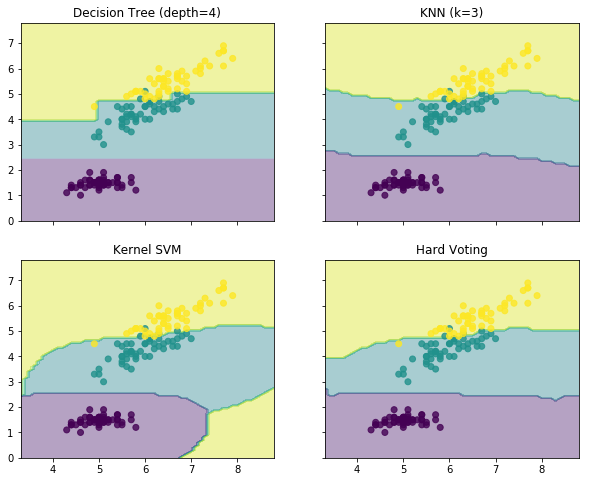

In [28]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=3)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), 
                                    ('knn', clf2),
                                    ('svc', clf3)],
                        voting='hard')

# Fit classifiers
clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=3)',
                         'Kernel SVM', 'Hard Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()